# Adversarial Image Captioning Attack

### Import Libraries, Set Seeds, and Select GPU

In [3]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [4]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


### Load COCO Mini Dataset

In [6]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [7]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [8]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [11]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


### Image Loading Helper

In [12]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


### Visual Inspection of a Sample Image

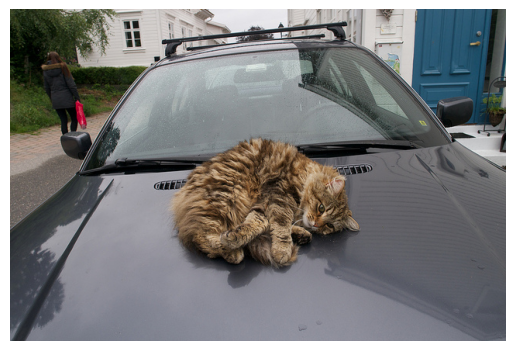

Image index: 6000, image_id: 190360
Ground truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [50]:
# Choose an image to show
idx = 6000

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


### Load ViT-GPT2

In [17]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


In [18]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids = model.generate(
        pixel_values,
        max_length=max_length,
        num_beams=1)

    # Run decoder once over full sequence to get cross-attentions
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [19]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).
    
    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len]
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len]

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # [patch_size^2]

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [20]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap\n(sentence-based)", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


### Example: Pick an Image, Get Caption and Attention and Visualize

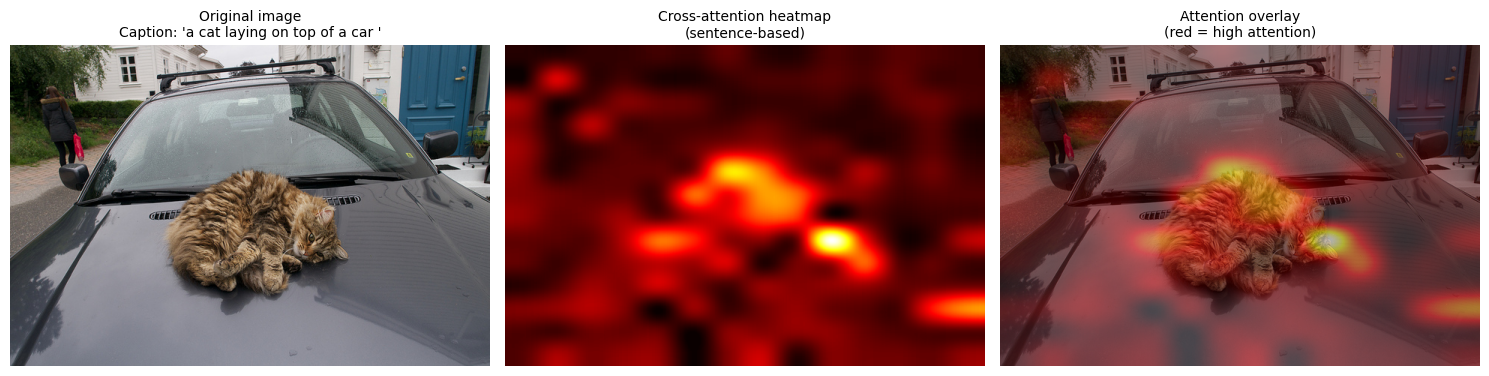

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [51]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")